In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import os
import torch
import sys
from pathlib import Path

import pickle

is_colab = 'google.colab' in sys.modules

if is_colab:
    print("Running on Google Colab")
    from model import *
    from train import *
    from utils import *
else:
    print("Running locally or on another platform")
    root = Path.cwd().parent
    if str(root) not in sys.path:
        sys.path.append(str(root))

    from src.model import *
    from src.train import *
    from src.utils import *

Running locally or on another platform


## GPU

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


## Load Dataset

In [44]:
transform = transforms.ToTensor() # it applies the normalization
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
# batching with size of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## Categories

In [45]:
categories = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot']

## Loss Function

In [46]:
# CrossEntropy is used for classification
criterion = torch.nn.CrossEntropyLoss()

## Models

In [47]:
# Define the directory and file path separately
records_dir = '../data'
records_path = os.path.join(records_dir, 'training_records.pkl')

if os.path.exists(records_path):
    print(f"Loading existing records from {records_path}...")
    all_records = torch.load(records_path, map_location=device, weights_only=False)
    record1 = all_records['record1']
    record2 = all_records['record2']
    record3 = all_records['record3']
    model1 = all_records['model1']
    model2 = all_records['model2']
    model3 = all_records['model3']
else:
    print("No existing records found. Starting training...")

    # Configuration 1: Baseline + SGD
    print("Training Configuration 1...")
    model1 = FashionClassifier_Baseline()
    opt_SGD = torch.optim.SGD(model1.parameters(), lr=0.01)
    record1 = train_model(model1, train_loader, test_loader, criterion, opt_SGD, device)

    # Configuration 2: 2Hidden + Adam
    print("Training Configuration 2...")
    model2 = FashionClassifier_2Hidden()
    opt_Adam = torch.optim.Adam(model2.parameters(), lr=0.001)
    record2 = train_model(model2, train_loader, test_loader, criterion, opt_Adam, device)

    # Configuration 3: 3Hidden + AdamW + Dropout
    print("Training Configuration 3...")
    model3 = FashionClassifier_3Hidden()
    opt_AdamW = torch.optim.AdamW(model3.parameters(), lr=0.001)
    record3 = train_model(model3, train_loader, test_loader, criterion, opt_AdamW, device)

    # Save all records to a single dictionary
    all_records = {
        'record1': record1,
        'record2': record2,
        'record3': record3,
        'model1': model1,
        'model2': model2,
        'model3': model3
    }

    if not os.path.exists(records_dir):
        os.makedirs(records_dir)
    torch.save(all_records, records_path)
    print(f"Training complete. Records saved to {records_path}.")

Loading existing records from ../data\training_records.pkl...


2 Hidden + Adam is the best model with the highest accuracy of both training and validation.

## Plot Confusion Matrix of the Best Model

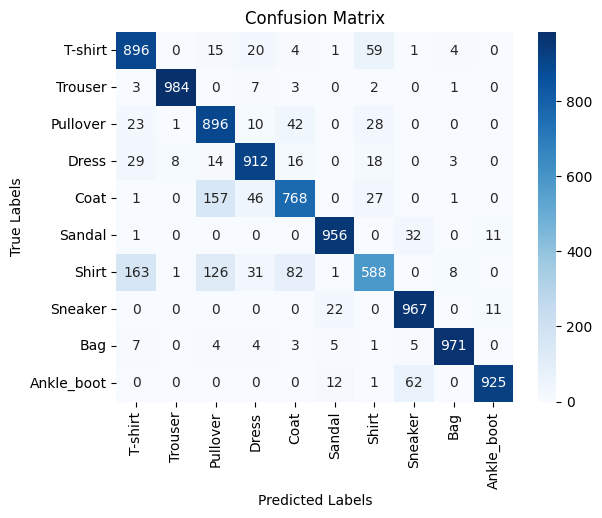

In [48]:
generate_confusion_matrix(model2, test_loader, criterion, device, categories)

## Plot Training Loss and Validation Accuracy

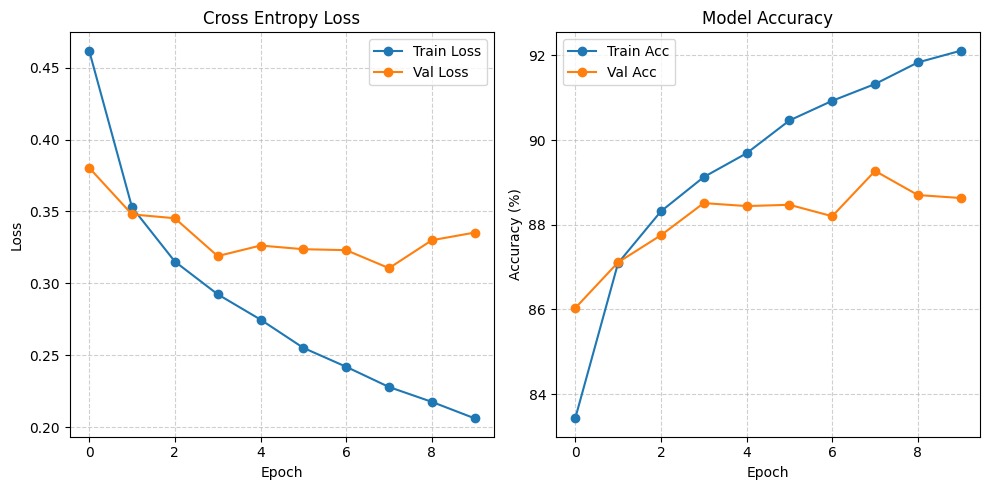

In [49]:
plot_training_results(record2[0], record2[1], record2[2], record2[3])

# Cost Matrix and Cost-weighted Accuracy

In [50]:
#label names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Cost levels
COST_LOW = 1
COST_MED = 5
COST_HIGH = 10

# Default cost for wrong prediction, baseline cost for all other incorrect predictions
DEFAULT_WRONG_COST = 2


In [51]:
cost_matrix = build_cost_matrix()
cost_matrix


tensor([[ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2., 10.,  2.,  0.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  0.,  2.,  5.,  2.,  2.],
        [10.,  2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  0.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  2.,  0.]])

In [52]:
# Run prediction collection
y_true_test, y_pred_test = get_test_predictions(model2, test_loader, device)
print("Test predictions collected:", y_true_test.shape[0])


Test predictions collected: 10000


In [53]:
#Computing standard accuracy
accuracy = standard_accuracy(y_true_test, y_pred_test)
print(f"Standard Test Accuracy: {accuracy:.4f}")

#compute weighted accuracy
total_cost, avg_cost, cw_accuracy = cost_weighted_metrics(
    y_true_test, y_pred_test, cost_matrix
)

print("Total Misclassification Cost:", total_cost)
print("Average Cost per Item:", avg_cost)
print("Cost-weighted Accuracy:", cw_accuracy)


Standard Test Accuracy: 0.8863
Total Misclassification Cost: 5111.0
Average Cost per Item: 0.5110999941825867
Cost-weighted Accuracy: 0.9488900005817413


Standard accuracy treats all classification errors equally. However, in StyleSort’s business context, some errors lead to significantly higher return rates than others. To account for this, a cost matrix was introduced and a cost-weighted accuracy metric was calculated to solve this problem.

In [54]:
#Count misclassifications by (true, predicted) pair + their cost
ranked_pairs, pair_counts, pair_total_cost = cost_breakdown(
    y_true_test, y_pred_test, cost_matrix, class_names, top_k=10
)


Top 10 most costly misclassification pairs:

Rank  True → Pred                    Count    Cost/err   Total cost
---------------------------------------------------------------------------
1     Shirt → T-shirt/top            163      10.00      1630.00   
2     Coat → Pullover                157      10.00      1570.00   
3     Ankle boot → Sneaker           62       5.00       310.00    
4     Shirt → Pullover               126      2.00       252.00    
5     Shirt → Coat                   82       2.00       164.00    
6     Sandal → Sneaker               32       5.00       160.00    
7     T-shirt/top → Shirt            59       2.00       118.00    
8     Coat → Dress                   46       2.00       92.00     
9     Pullover → Coat                42       2.00       84.00     
10    Shirt → Dress                  31       2.00       62.00     


## Confidence Threshold Plot

In [55]:
thresholds, accuracy_scores, acceptance_rates = analyze_confidence_thresholds(model2, test_loader, device)

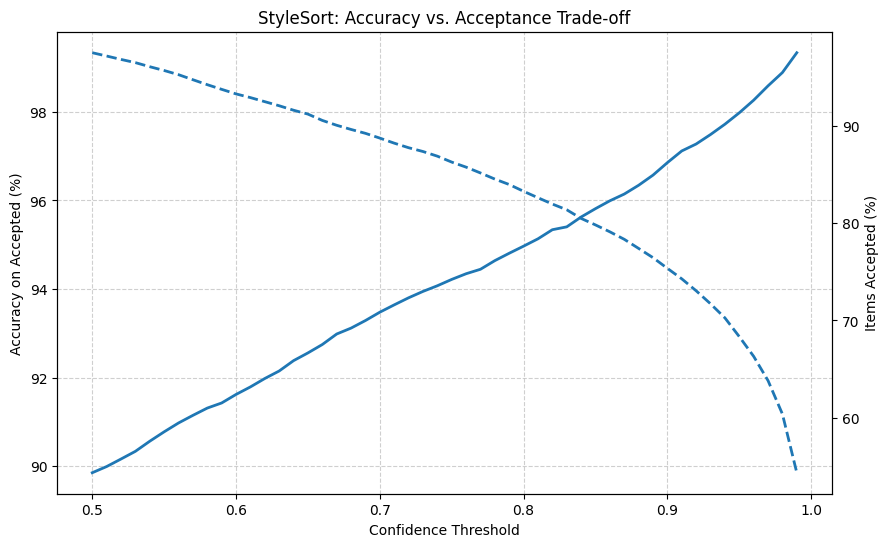

In [56]:
plot_confidence_analysis(thresholds, accuracy_scores, acceptance_rates)

## Misclassification Examples

In [57]:
misclassified_examples = get_misclassified_examples(
    model2, test_loader, device, max_examples=10
)

len(misclassified_examples)


10

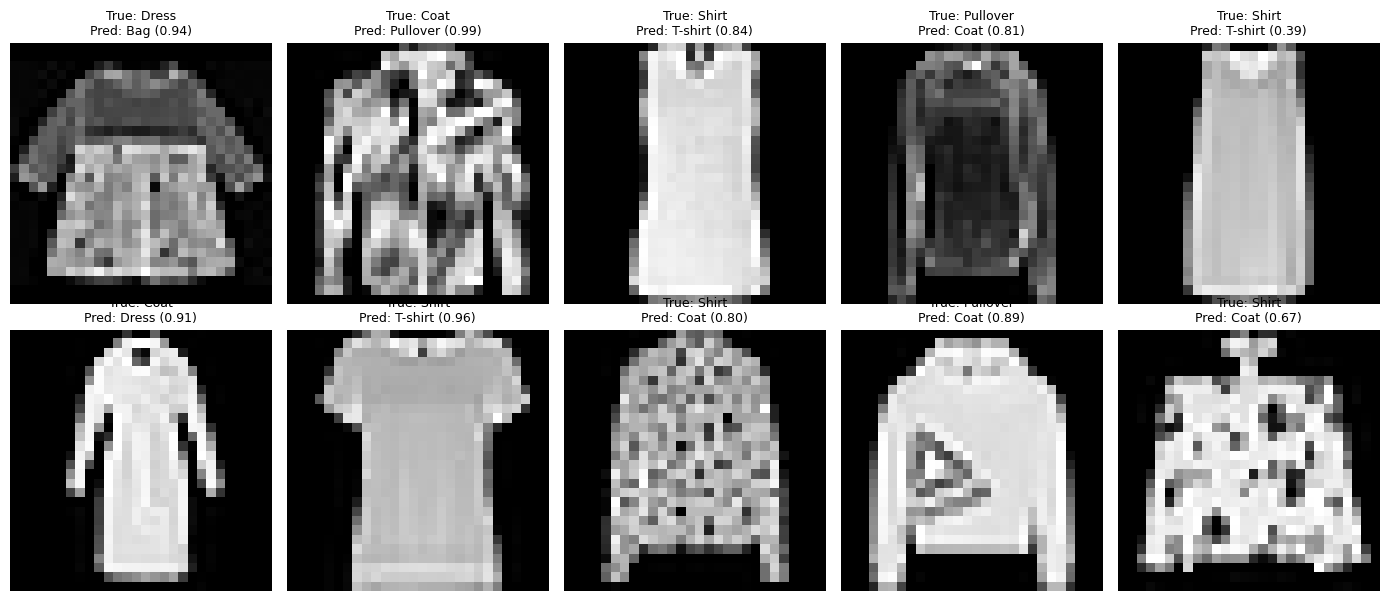

In [58]:
plot_misclassified_examples(misclassified_examples, categories)